In [3]:
from openai import AzureOpenAI
import anthropic
import ollama
import requests
import json
from dotenv import load_dotenv
import os
from IPython.display import display, update_display, Markdown
from bs4 import BeautifulSoup
import re

In [49]:
load_dotenv(override=True)

azure_ai_foundary_api_key = os.getenv("AZURE_AI_FOUNDARY_API_KEY")
azure_oai_endpoint = os.getenv("AZURE_OAI_ENDPOINT")

azure_dalle_api_key = os.getenv("AZURE_DALLE_API_KEY")
azure_dalle_endpoint = os.getenv("AZURE_DALLE_ENDPOINT")

azure_audio_api_key = os.getenv("AZURE_AUDIO_API_KEY")
azure_audio_endpoint = os.getenv("AZURE_AUDIO_ENDPOINT")

In [12]:
azure_ai_foundary = AzureOpenAI(
    azure_endpoint = azure_oai_endpoint,
    api_key = azure_ai_foundary_api_key,
    api_version = "2025-01-01-preview"
)


## Tools
Tools allows the LLM to execute actions. Eg if there is a calculator tool then the LLM can use that whenever the user asks for a calculation.

In [65]:
product_prices = {'keyboard': 100, 'mouse': 40, 'motherboard': 143}

def get_product_price(product):
    """Returns the price of a computer part"""
    print(f'Price requested for {product}')
    return product_prices.get(product.lower(), 'Unknown')


# define the tool metadata for the LLM
# The structure follows the structure that open ai expects
computer_price_function = {
    "name": "get_product_price",
    "description": "Returns the price of a computer part. Use this whenever you need to know the price of a computer part. Example: If a customer asks for the price of a mouse, use his function.",
    "parameters": {
        "type": "object",
        "properties": {
            "product": {
                "type": "string",
                "description": "The name of the computer part that customer wants to buy"
            }
        },
        "required": ["product"],
        "additionalProperties": False
    }
}

tools = [{"type": "function", "function": computer_price_function}]

# This will be used to handle the tool request from open ai LLM
def tool_handler(message):
    # extract the func related args 
    tool_call = message.tool_calls[0]
    args = json.loads(tool_call.function.arguments)
    computer_part = args.get('product')

    print(f'Tool handler ........... {computer_part}')
    print(message)
    # use the func
    price = get_product_price(computer_part)

    response = {
        "role": "tool",
        "content": json.dumps({"product": computer_part, "price": price}),
        "tool_call_id": tool_call.id
    }

    return response, computer_part

In [66]:
def chat(msg, history):
    system_message = "You are an expert assistant who specializes in computer related stuff. \
    You help the user precise one line responses. \
    If rely on functions to get the accuracy and in case you dont know about something, clearly mention that."

    print(f"Chat history: {history}")
    
    model = "gpt-4o-mini"
    
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": msg}]

    # NOTE - pass the tools object
    response = azure_ai_foundary.chat.completions.create(model=model, messages=messages, tools=tools)
    
    # whenever the llm wants to use a tool, it will have that as the finish_reason
    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        tool_response, computer_part = tool_handler(message)

        # messages + [Received LLM tool call msg] + [our tool handler response]
        messages.append(message)
        messages.append(tool_response)

        response = azure_ai_foundary.chat.completions.create(model=model, messages=messages)

    return response.choices[0].message.content

In [8]:
import gradio as gr

c:\Users\SeekerG\Desktop\Dev\github\llm-apps\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [64]:
gr.ChatInterface(
    fn=chat,
    type="messages"
).launch(server_port=10235)

* Running on local URL:  http://127.0.0.1:10235

To create a public link, set `share=True` in `launch()`.


Chat history: []
Tool handler ........... mouse
ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_44Y5rf5nfVhK0zCpIYViWF0G', function=Function(arguments='{"product":"mouse"}', name='get_product_price'), type='function')])
Price requested for mouse
Chat history: [{'role': 'user', 'metadata': None, 'content': 'price of a mouse', 'options': None}, {'role': 'assistant', 'metadata': None, 'content': 'The price of a mouse is $40.', 'options': None}]


## Image generation

In [16]:
import base64
from PIL import Image
from io import BytesIO
from IPython.display import display

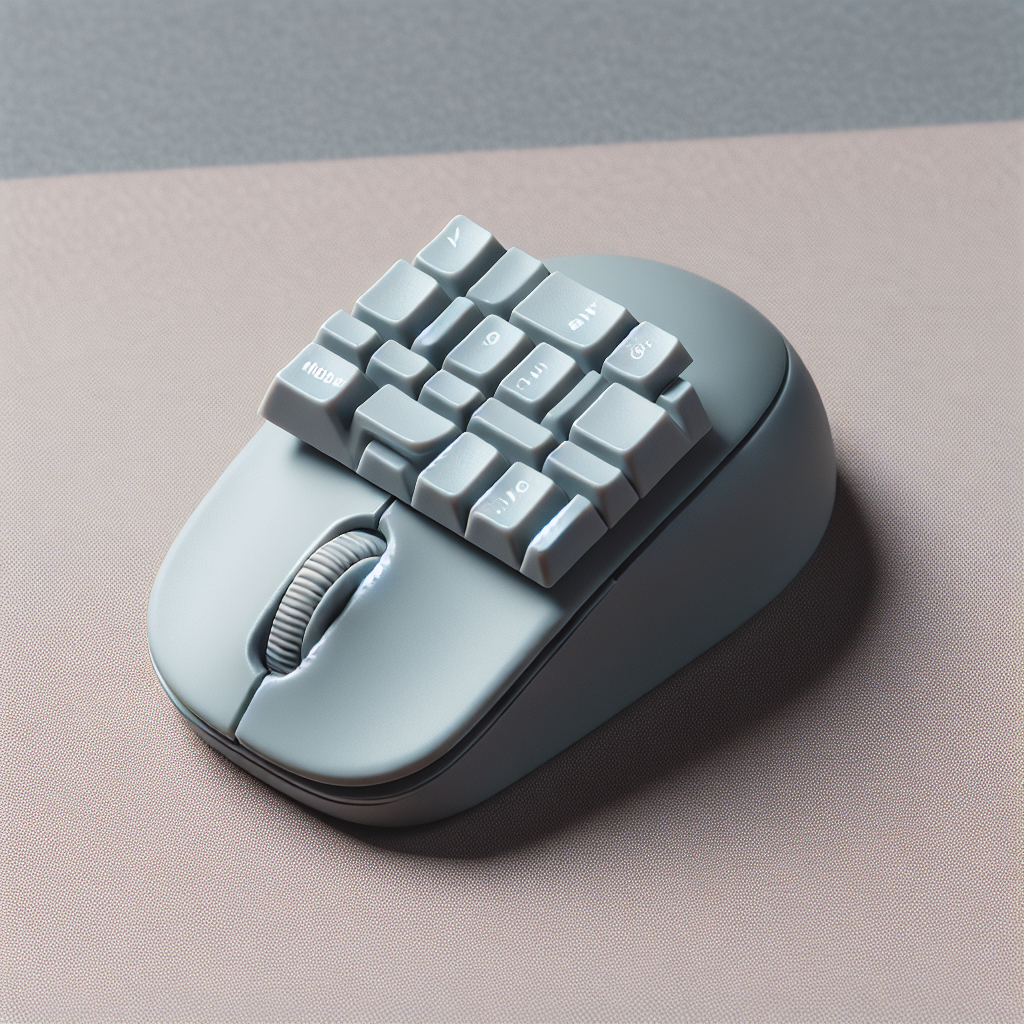

In [17]:
img_gen_client = AzureOpenAI(
    azure_endpoint=azure_dalle_endpoint,
    api_key=azure_dalle_api_key,
    api_version="2024-02-01"
)

def generate_img(prompt: str):
    model = "dall-e-3"
    img_response = img_gen_client.images.generate(
        model=model,
        prompt=prompt,
        size='1024x1024',
        n=1,
        response_format="b64_json"
    )

    img_b64 = img_response.data[0].b64_json
    # decode the base64 data to img
    img_bytes = base64.b64decode(img_b64)
    img = Image.open(BytesIO(img_bytes))

    return img

img = generate_img("mouse with a keyboard on top of it")
display(img)

## Audio Output

### Text to Speech (TTS)

In [14]:
from pydub import AudioSegment
from pydub.playback import play
from openai.helpers import LocalAudioPlayer
from IPython.display import Audio

In [51]:
audio_gen_client = AzureOpenAI(
    azure_endpoint=azure_audio_endpoint,
    api_key=azure_audio_api_key,
    api_version="2025-03-01-preview"
)

def generate_audio(prompt: str, tone: str=None):

    tone = tone if tone else """Voice Affect: Soft, gentle, soothing; embody tranquility.\n\nTone: Calm, reassuring, peaceful; convey genuine warmth and serenity.\n\nPacing: Slow, deliberate, and unhurried; pause gently after instructions to allow the listener time to relax and follow along.\n\nEmotion: Deeply soothing and comforting; express genuine kindness and care.\n\nPronunciation: Smooth, soft articulation, slightly elongating vowels to create a sense of ease.\n\nPauses: Use thoughtful pauses, especially between breathing instructions and visualization guidance, enhancing relaxation and mindfulness."""
    audio_response = audio_gen_client.audio.speech.create(
        model="gpt-4o-mini-tts",
        voice="alloy",
        input=prompt,
        instructions=tone,
        response_format="mp3",
    )

    return audio_response

audio_response = generate_audio("Hello, this is a test of the text-to-speech functionality.", tone="super excited")


In [52]:
def play_audio_stream(audio_response):
    audio_stream = BytesIO(audio_response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))

play_audio_stream(audio_response)

#### Using OpenAI's helper

In [53]:
# we can also use openai helper to play the audio
async def generate_and_play_audio(prompt: str, tone: str=None):

    tone = tone if tone else """Voice Affect: Soft, gentle, soothing; embody tranquility.\n\nTone: Calm, reassuring, peaceful; convey genuine warmth and serenity.\n\nPacing: Slow, deliberate, and unhurried; pause gently after instructions to allow the listener time to relax and follow along.\n\nEmotion: Deeply soothing and comforting; express genuine kindness and care.\n\nPronunciation: Smooth, soft articulation, slightly elongating vowels to create a sense of ease.\n\nPauses: Use thoughtful pauses, especially between breathing instructions and visualization guidance, enhancing relaxation and mindfulness."""
    audio_response = audio_gen_client.audio.speech.create(
        model="gpt-4o-mini-tts",
        voice="alloy",
        input=prompt,
        instructions=tone,
        response_format="pcm",
    )

    await LocalAudioPlayer().play(audio_response)

await generate_and_play_audio("Hello, this is a test of the text-to-speech functionality.", tone="super excited")

### Multi-Modality: Text input to audio response

In [56]:
def audio_response(messages):
    client = AzureOpenAI(
        azure_endpoint=azure_audio_endpoint,
        api_key=azure_audio_api_key,
        api_version="2025-01-01-preview"
    )
    
    MODEL = "gpt-4o-mini-audio-preview"
    response = client.chat.completions.create(
        model=MODEL,
        modalities=["audio", "text"],
        audio={"voice": "alloy", "format": "mp3"},
        messages=messages
    )

    return response.choices[0].message.audio.data

audio_b64 = audio_response([{"role": "user", "content": "Tell me a joke"}])
audio_bytes=base64.b64decode(audio_b64)

output_filename = "response.mp3"
with open(output_filename, "wb") as f:
    f.write(audio_bytes)

display(Audio(output_filename, autoplay=True))

## Multi-modal assistant with Tools usage

Assistant will use the tool get the price of a computer part and will also generate an image for that part. The response will be spoken verbally by the assistant.

In [78]:
async def multi_modal_response(history):
    system_message = "You are an expert assistant who specializes in computer related stuff. \
    You help the user precise one line responses. \
    If rely on functions to get the accuracy and in case you dont know about something, clearly mention that."

    model = "gpt-4o-mini"
    
    # NOTE - last usr msg is already appended to the history
    messages = [{"role": "system", "content": system_message}] + history

    # NOTE - pass the tools object
    response = azure_ai_foundary.chat.completions.create(model=model, messages=messages, tools=tools)
    
    img = None
    # whenever the llm wants to use a tool, it will have that as the finish_reason
    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        tool_response, computer_part = tool_handler(message)

        print(f"Tool response: {tool_response}")
        print(f"Computer part: {computer_part}")

        # messages + [Received LLM tool call msg] + [our tool handler response]
        messages.append(message)
        messages.append(tool_response)

        response = azure_ai_foundary.chat.completions.create(model=model, messages=messages)

        # generate image of product
        img = generate_img(computer_part)

    assistant_reply = response.choices[0].message.content
    history += [{"role": "assistant", "content": assistant_reply}]    

    # read out the audio response
    await generate_and_play_audio(assistant_reply, tone="super excited")
    return history, img


# Setup the gradio UI
with gr.Blocks() as ui:
    gr.Markdown("# Computer Buying Assistant")

    with gr.Row():
        chatbot = gr.Chatbot(height=400, type="messages")
        img_output = gr.Image(height=400)
    
    with gr.Row():
        input_box = gr.Textbox(label="Enter your message")

    with gr.Row():
        clear = gr.Button("Clear")

    # Now we will add event handlers for the input box and the clear button
    def input_handler(msg, history):
        """Whenever the user submits the message, we will update the history and set the input textbox value to empty,
        to give an impression of a chat with the assistant. Since we are appending the user message to the history, 
        we will also need to set the updated history."""
        history += [{"role": "user", "content": msg}]
        return "", history
    
    # Whenever the user submits the message, we will call the input_handler to update the history and set the input box value to empty.
    # Then we will call the multi_modal_response function to get the assistant reply and image response.
    # multi_modal_response will return the updated history and image response.
    input_box.submit(input_handler, inputs=[input_box, chatbot], outputs=[input_box, chatbot]) \
        .then(multi_modal_response, inputs=chatbot, outputs=[chatbot, img_output])
    
    # When clear button, it calls the lambda which just returns None and that value
    # is assigned to the outputs.
    clear.click(lambda: (None, None), inputs=None, outputs=[chatbot, img_output], queue=False)
ui.launch(server_port=10242)

* Running on local URL:  http://127.0.0.1:10242

To create a public link, set `share=True` in `launch()`.


Tool handler ........... mouse
ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_4vLrNdOAfDK6ZUp1oE0FK2jg', function=Function(arguments='{"product":"mouse"}', name='get_product_price'), type='function')])
Price requested for mouse
Tool response: {'role': 'tool', 'content': '{"product": "mouse", "price": 40}', 'tool_call_id': 'call_4vLrNdOAfDK6ZUp1oE0FK2jg'}
Computer part: mouse
Tool handler ........... keyboard
ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_Eg5LupWTpQCuVqgrbz35kSbV', function=Function(arguments='{"product":"keyboard"}', name='get_product_price'), type='function')])
Price requested for keyboard
Tool response: {'role': 'tool', 'content': '{"product": "keyboard", "price": 100}', 'tool_call_id': 'call_Eg5LupWTpQCuVqgrbz35kSbV'}
Computer